In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [2]:
train = pd.read_csv('../data/new_train.csv', index_col='Date')
test = pd.read_csv('../data/new_test.csv', index_col='Date')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 41 columns):
Species           10506 non-null int64
Block             10506 non-null int64
Trap              10506 non-null int64
Latitude          10506 non-null float64
Longitude         10506 non-null float64
WnvPresent        10506 non-null float64
Month             10506 non-null int64
Weekday           10506 non-null int64
Week              10506 non-null int64
Year              10506 non-null int64
Tmax_s1           10506 non-null int64
Tmin_s1           10506 non-null int64
Tavg_s1           10506 non-null int64
Depart            10506 non-null int64
DewPoint_s1       10506 non-null int64
WetBulb_s1        10506 non-null int64
Heat_s1           10506 non-null int64
Cool_s1           10506 non-null int64
PrecipTotal_s1    10506 non-null float64
StnPressure_s1    10506 non-null float64
SeaLevel_s1       10506 non-null float64
ResultSpeed_s1    10506 non-null float64
ResultDir_

In [4]:
X = train.drop('WnvPresent', axis =1)
y = train['WnvPresent']

## Scaling 

In [5]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,Species,Block,Trap,Latitude,Longitude,Month,Weekday,Week,Year,Tmax_s1,...,PrecipTotal_s2,StnPressure_s2,SeaLevel_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,SunsetHour,SunsetMinute,SunriseHour,SunriseMinute
0,-0.113161,0.218265,-1.737760,1.007225,-1.047388,-2.522009,-1.166737,-2.140018,-1.094163,0.743177,...,-0.448547,1.140441,1.150732,-0.036184,-0.194514,-0.028583,0.800786,-0.690669,-0.775423,-0.644694
1,0.951177,0.218265,-1.737760,1.007225,-1.047388,-2.522009,-1.166737,-2.140018,-1.094163,0.743177,...,-0.448547,1.140441,1.150732,-0.036184,-0.194514,-0.028583,0.800786,-0.690669,-0.775423,-0.644694
2,0.951177,1.081102,-1.579219,1.364706,-0.718799,-2.522009,-1.166737,-2.140018,-1.094163,0.743177,...,-0.448547,1.140441,1.150732,-0.036184,-0.194514,-0.028583,0.800786,-0.690669,-0.775423,-0.644694
3,-0.113161,1.779590,-1.420678,1.179300,-1.294214,-2.522009,-1.166737,-2.140018,-1.094163,0.743177,...,-0.448547,1.140441,1.150732,-0.036184,-0.194514,-0.028583,0.800786,-0.690669,-0.775423,-0.644694
4,0.951177,1.779590,-1.420678,1.179300,-1.294214,-2.522009,-1.166737,-2.140018,-1.094163,0.743177,...,-0.448547,1.140441,1.150732,-0.036184,-0.194514,-0.028583,0.800786,-0.690669,-0.775423,-0.644694


Creating a scaled version of test in the event that a scaled model performs better.

In [6]:
ids = test['Id']
test.drop('Id', axis=1, inplace=True)

In [7]:
test_scaled = ss.transform(test)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns)

## Train Test Split 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled_df, y)

In [9]:
y_train.mean(), y_test.mean()

(0.05178322122096713, 0.054434716406547394)

In [10]:
y_scaled_train.mean(), y_scaled_test.mean()

(0.05216398020053306, 0.053292729349067376)

## Oversampling Minority Class (Presence of West Nile Virus)

In [11]:
sm = SMOTE()
X_resample, y_resample = sm.fit_sample(X_train, y_train)
X_scaled_res, y_scaled_res = sm.fit_sample(X_scaled_train, y_scaled_train)

## Scoring Function

In [12]:
def auc_score(model, scaled=False):
    if scaled:
        preds = model.predict_proba(X_scaled_test)[:,1]
    else:
        preds = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, preds)    

## Random Forest

Using unscaled data.

In [13]:
rf = RandomForestClassifier(n_estimators=1000)
model = rf.fit(X_resample, y_resample)
rf.score(X_test, y_test)

0.9196802436239055

In [14]:
auc_score(rf)

0.8054274630361586

Using scaled data.

In [15]:
rf_scaled = RandomForestClassifier(n_estimators=1000)
rf_scaled.fit(X_scaled_res, y_scaled_res)
rf.score(X_scaled_test, y_scaled_test)

0.9467072706509326

In [16]:
auc_score(rf_scaled, scaled=True)

0.47439838744186563

## Logistic Regression

In [17]:
logreg = LogisticRegression()
logreg.fit(X_resample, y_resample)
logreg.score(X_test, y_test)

0.6981347544727826

In [18]:
auc_score(logreg)

0.796380752902492

In [19]:
logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_scaled_res, y_scaled_res)
logreg_scaled.score(X_scaled_test, y_scaled_test)

0.7076513132851161

In [20]:
auc_score(logreg_scaled, scaled=True)

0.4760438836525793

## Support Vector Classifier

In [69]:
svc = SVC(kernel='linear', probability=True)
svc.fit(X_resample, y_resample)
svc.score(X_test, y_test)

0.704225352112676

In [70]:
auc_score(svc)

0.7940047070481854

In [71]:
svc_scaled = SVC(kernel='linear', probability=True)
svc_scaled.fit(X_scaled_res, y_scaled_res)
svc_scaled.score(X_scaled_test, y_scaled_test)

0.6947087933003426

In [72]:
auc_score(svc_scaled, scaled=True)

0.47416331655462096

## XGBoost

In [25]:
# XGBoost does not like that X_test is still a DataFrame but X_resample
# is a numpy array. Convert X_resample to a DataFrame for simplicity.
X_resample = pd.DataFrame(X_resample, columns=X_train.columns)

In [26]:
model = XGBClassifier()
xgm = model.fit(X_resample, y_resample, eval_metric=roc_auc_score)
xgm.score(X_test, y_test)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8549676437000381

In [27]:
auc_score(xgm)

0.8281237683411596

In [28]:
X_scaled_res = pd.DataFrame(X_scaled_res, columns=X_train.columns)

In [29]:
model = XGBClassifier()
xgm_scaled = model.fit(X_scaled_res, y_scaled_res, eval_metric=roc_auc_score)
xgm_scaled.score(X_scaled_test, y_scaled_test)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.825656642558051

In [30]:
auc_score(xgm_scaled, scaled=True)

0.48321424951859737

## Adaboost

In [31]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
ada.fit(X_resample, y_resample)
ada.score(X_test, y_test)

0.8237533307955843

In [32]:
auc_score(ada)

0.7967636228505793

## Creating Submissions

In [33]:
def get_name(func):
    name = str(func.__class__)
    dot_index = name.count('.')
    dot_count = 0
    new_name = ''
    for char in name:
        if char == '.':
            dot_count += 1
        if dot_count == dot_index:
            new_name += char
    return f'{new_name[1:-2]}_'

In [34]:
def create_filename(model, scaled=False):
    model_name = get_name(model)
    is_scaled = 'scaled_' if scaled else 'unscaled_'
    name = f'{model_name}{is_scaled}submission'
    prev_files = listdir('../submissions')
    count = sum([1 for file in prev_files if name in file])
    num = f'_{count}' if count else ''
    return f'{name}{num}.csv'

In [35]:
def create_submission(model, scaled=False):
    preds = model.predict_proba(test)[:,1]
    ID = ids.astype('int32').reset_index(drop=True)
    df = pd.DataFrame({'Id': ID, 'WnvPresent': preds})
    filename = create_filename(model, scaled=scaled)
    df.to_csv(f'../submissions/{filename}', index=False)
    print(f'{filename} was created and saved in the submissions folder.')
    return df.head()

In [36]:
create_submission(ada)

AdaBoostClassifier_unscaled_submission_1.csv was created and saved in the submissions folder.


,Id,WnvPresent
0,1,0.456754
1,2,0.441813
2,3,0.456603
3,4,0.435192
4,5,0.435192


## Visuals, Feature Importances, and Coefficients

In [37]:
# Credit to this medium article: https://medium.com/@aneesha/visualising-top-features-
# in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Plot them thangs. 
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, 2 * top_features),
        feature_names[top_coefficients],
        rotation=60, ha='right')

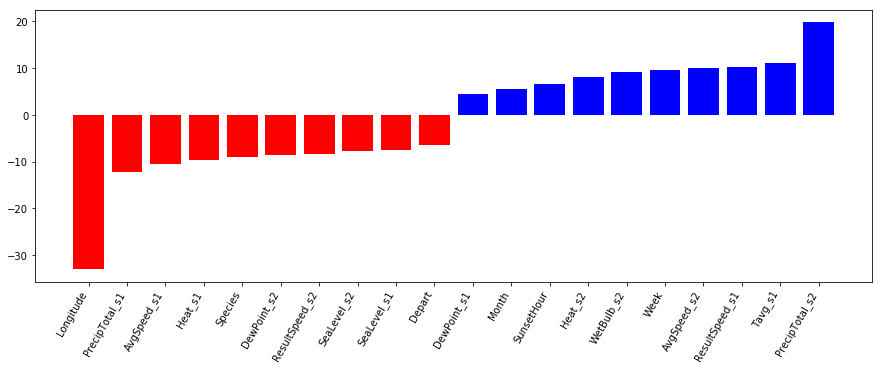

In [73]:
plot_coefficients(svc, X_train.columns)

In [68]:
sorted(list(zip(*logreg.coef_, X_train.columns)))

[(-4.6839858164141335, 'Tavg_s2'),
 (-4.51331906957432, 'Heat_s1'),
 (-3.5144978389653008, 'Heat_s2'),
 (-3.3068166999759283, 'Tavg_s1'),
 (-3.034852998958698, 'Longitude'),
 (-2.035290994821143, 'SeaLevel_s1'),
 (-1.5542763096637517, 'SeaLevel_s2'),
 (-1.2314791692551175, 'PrecipTotal_s1'),
 (-0.917125417795727, 'StnPressure_s1'),
 (-0.9149698467332866, 'Latitude'),
 (-0.7063998336195334, 'DewPoint_s2'),
 (-0.6710954344288655, 'Species'),
 (-0.581332963315073, 'ResultSpeed_s2'),
 (-0.5799225804696022, 'AvgSpeed_s1'),
 (-0.5273931704776295, 'Depart'),
 (-0.4829733440704032, 'SunriseHour'),
 (-0.32603457213371057, 'SunsetHour'),
 (-0.20346024274401422, 'Tmin_s1'),
 (-0.09722292694770276, 'ResultDir_s2'),
 (-0.06347752491046274, 'Month'),
 (-0.029417540137917784, 'Tmax_s2'),
 (-0.018867172110117007, 'Tmax_s1'),
 (-0.014787555117623153, 'SunriseMinute'),
 (-0.009297202350398113, 'SunsetMinute'),
 (0.0013921044239391812, 'Trap'),
 (0.002313143494241399, 'Block'),
 (0.004424602203325849, 'S

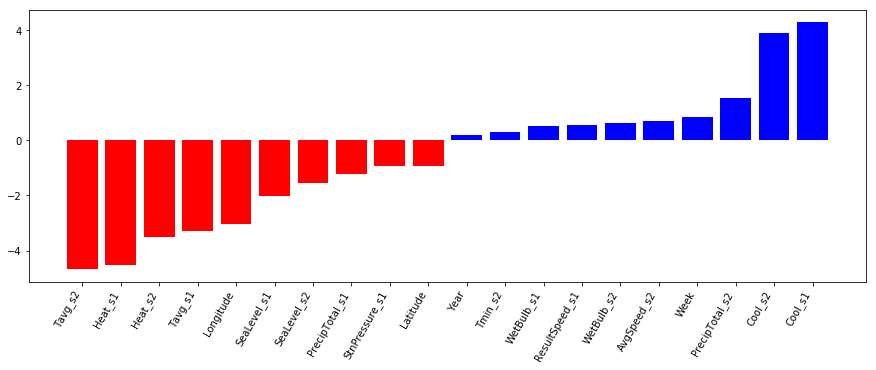

In [39]:
plot_coefficients(logreg, X_train.columns)

In [40]:
def plot_importances(classifier, feature_names, top_features=10, tree_based=False):
    coef = classifier.feature_importances_.ravel()
    top_importances = np.argsort(coef)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(top_features), coef[top_importances], color='blue')
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, top_features),
        feature_names[top_importances],
        rotation=60, ha='right')

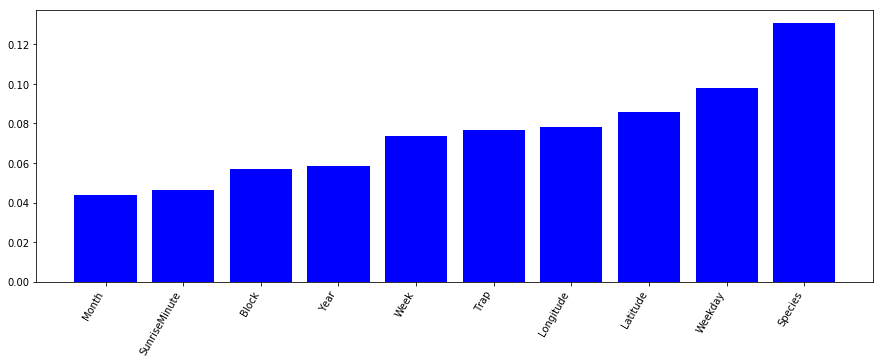

In [41]:
plot_importances(xgm, X_train.columns)

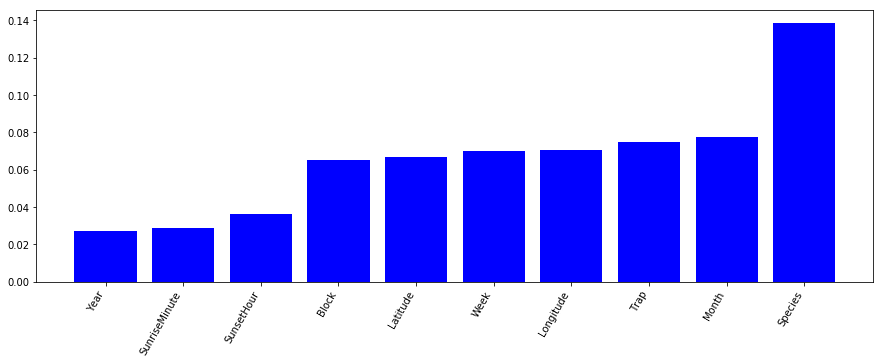

In [42]:
plot_importances(rf, X_train.columns)

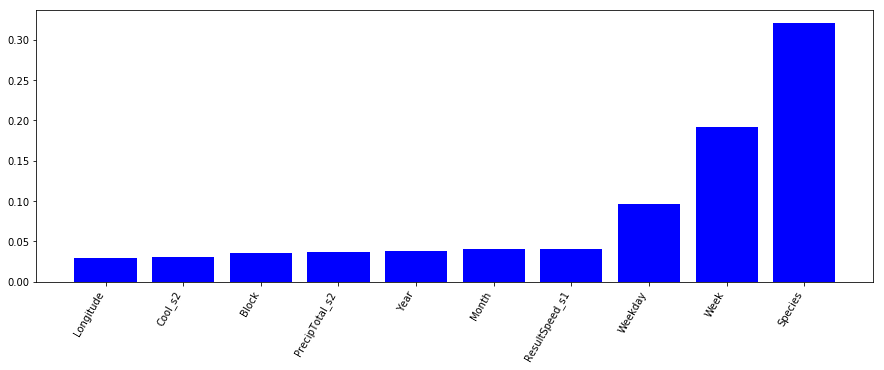

In [43]:
plot_importances(ada, X_train.columns)

## Confusion Matrices

In [44]:
def confusion_metrics(row):
    
    if row['WnvPresent'] == 1.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "True Positive"
    if row['WnvPresent'] == 1.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "False Negative"
        
    if row['WnvPresent'] == 0.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "True Negative"
    if row['WnvPresent'] == 0.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "False Positive"
        
    return row

In [45]:
rf_df = pd.DataFrame(rf.predict(X_test), columns=['predicted_label'])
rf_df['WnvPresent'] = y_test.reset_index(drop=True)
rf_df['predicted_proba'] = rf.predict_proba(X_test)[:,1]
rf_df.tail(10)

,predicted_label,WnvPresent,predicted_proba
2617,0.0,0.0,0.004000
2618,0.0,0.0,0.000000
2619,0.0,0.0,0.000000
2620,0.0,1.0,0.000000
2621,0.0,0.0,0.000000
2622,0.0,0.0,0.000000
2623,0.0,0.0,0.003500
2624,0.0,0.0,0.217997
2625,0.0,0.0,0.012693
2626,0.0,0.0,0.001000


In [47]:
logreg_df = pd.DataFrame(logreg.predict(X_test), columns=['predicted_label'])
logreg_df['WnvPresent'] = y_test.reset_index(drop=True)
logreg_df['predicted_proba'] = logreg.predict_proba(X_test)[:,1]
logreg_df.tail(10)

,predicted_label,WnvPresent,predicted_proba
2617,0.0,0.0,0.341486
2618,0.0,0.0,0.294743
2619,0.0,0.0,0.000176
2620,1.0,1.0,0.637479
2621,0.0,0.0,0.005564
2622,0.0,0.0,0.025101
2623,0.0,0.0,0.100957
2624,0.0,0.0,0.219089
2625,0.0,0.0,0.424068
2626,1.0,0.0,0.691023


In [49]:
xgm_df = pd.DataFrame(xgm.predict(X_test), columns=['predicted_label'])
xgm_df['WnvPresent'] = y_test.reset_index(drop=True)
xgm_df['predicted_proba'] = xgm.predict_proba(X_test)[:,1]
xgm_df.tail(10)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,predicted_label,WnvPresent,predicted_proba
2617,0.0,0.0,0.144459
2618,0.0,0.0,0.094848
2619,0.0,0.0,0.013138
2620,0.0,1.0,0.403697
2621,0.0,0.0,0.007651
2622,0.0,0.0,0.003857
2623,0.0,0.0,0.044088
2624,0.0,0.0,0.164682
2625,0.0,0.0,0.219074
2626,0.0,0.0,0.097900


In [50]:
ada_df = pd.DataFrame(ada.predict(X_test), columns=['predicted_label'])
ada_df['WnvPresent'] = y_test.reset_index(drop=True)
ada_df['predicted_proba'] = ada.predict_proba(X_test)[:,1]
ada_df.tail(10)

,predicted_label,WnvPresent,predicted_proba
2617,0.0,0.0,0.483248
2618,0.0,0.0,0.481683
2619,0.0,0.0,0.439956
2620,0.0,1.0,0.491803
2621,0.0,0.0,0.444969
2622,0.0,0.0,0.456001
2623,0.0,0.0,0.480337
2624,0.0,0.0,0.492147
2625,0.0,0.0,0.491973
2626,0.0,0.0,0.482821


In [74]:
svc_df = pd.DataFrame(svc.predict(X_test), columns=['predicted_label'])
svc_df['WnvPresent'] = y_test.reset_index(drop=True)
svc_df['predicted_proba'] = svc.predict_proba(X_test)[:,1]
svc_df.tail(10)

,predicted_label,WnvPresent,predicted_proba
2617,0.0,0.0,0.379299
2618,0.0,0.0,0.336926
2619,0.0,0.0,0.000711
2620,1.0,1.0,0.679896
2621,0.0,0.0,0.025552
2622,0.0,0.0,0.025100
2623,0.0,0.0,0.156497
2624,0.0,0.0,0.092719
2625,0.0,0.0,0.415381
2626,1.0,0.0,0.560055


In [51]:
def get_metrics(df):
    TP = df.loc['Actual Positive', 'Predicted Positive']
    TN = df.loc['Actual Negative', 'Predicted Negative']
    FP = df.loc['Actual Negative', 'Predicted Positive']
    FN = df.loc['Actual Positive', 'Predicted Negative']
    acc = (TP + TN) / (TP + FN + FP + TN)
    miss = 1 - acc
    recall = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    index_names = ['Accuracy', 
                   'Misclassifaction Rate', 
                   'Sensitivity/Recall', 
                   'Specificity',
                   'Precision']
    df = pd.DataFrame({'Metrics': [acc, miss, recall, spec, prec]}, index=index_names)
    return df

In [52]:
rf_cm = rf_df.apply(confusion_metrics, axis=1)['confusion_metric'].value_counts().sort_index()
rf_cm_df = pd.DataFrame({'Predicted Negative': [rf_cm[2], rf_cm[0]],
                         'Predicted Positive': [rf_cm[1], rf_cm[3]]},
                        index=['Actual Negative', 'Actual Positive'])
rf_cm_df

,Predicted Negative,Predicted Positive
Actual Negative,2374,110
Actual Positive,101,42


In [53]:
get_metrics(rf_cm_df)

,Metrics
Accuracy,0.919680
Misclassifaction Rate,0.080320
Sensitivity/Recall,0.293706
Specificity,0.955717
Precision,0.276316


In [54]:
logreg_cm = logreg_df.apply(confusion_metrics, axis=1)['confusion_metric'].value_counts().sort_index()
logreg_cm_df = pd.DataFrame({'Predicted Negative': [logreg_cm[2], logreg_cm[0]],
                          'Predicted Positive': [logreg_cm[1], logreg_cm[3]]},
                         index=['Actual Negative', 'Actual Positive'])
logreg_cm_df

,Predicted Negative,Predicted Positive
Actual Negative,1728,756
Actual Positive,37,106


In [55]:
get_metrics(logreg_cm_df)

,Metrics
Accuracy,0.698135
Misclassifaction Rate,0.301865
Sensitivity/Recall,0.741259
Specificity,0.695652
Precision,0.122970


In [56]:
xgm_cm = xgm_df.apply(confusion_metrics, axis=1)['confusion_metric'].value_counts().sort_index()
xgm_cm_df = pd.DataFrame({'Predicted Negative': [xgm_cm[2], xgm_cm[0]],
                          'Predicted Positive': [xgm_cm[1], xgm_cm[3]]},
                         index=['Actual Negative', 'Actual Positive'])
xgm_cm_df

,Predicted Negative,Predicted Positive
Actual Negative,2166,318
Actual Positive,63,80


In [57]:
get_metrics(xgm_cm_df)

,Metrics
Accuracy,0.854968
Misclassifaction Rate,0.145032
Sensitivity/Recall,0.559441
Specificity,0.871981
Precision,0.201005


In [58]:
ada_cm = ada_df.apply(confusion_metrics, axis=1)['confusion_metric'].value_counts().sort_index()
ada_cm_df = pd.DataFrame({'Predicted Negative': [ada_cm[2], ada_cm[0]],
                          'Predicted Positive': [ada_cm[1], ada_cm[3]]},
                         index=['Actual Negative', 'Actual Positive'])
ada_cm_df

,Predicted Negative,Predicted Positive
Actual Negative,2076,408
Actual Positive,55,88


In [59]:
get_metrics(ada_cm_df)

,Metrics
Accuracy,0.823753
Misclassifaction Rate,0.176247
Sensitivity/Recall,0.615385
Specificity,0.835749
Precision,0.177419


In [75]:
svc_cm = svc_df.apply(confusion_metrics, axis=1)['confusion_metric'].value_counts().sort_index()
svc_cm_df = pd.DataFrame({'Predicted Negative': [svc_cm[2], svc_cm[0]],
                          'Predicted Positive': [svc_cm[1], svc_cm[3]]},
                         index=['Actual Negative', 'Actual Positive'])
svc_cm_df

,Predicted Negative,Predicted Positive
Actual Negative,1740,744
Actual Positive,33,110


In [76]:
get_metrics(svc_cm_df)

,Metrics
Accuracy,0.704225
Misclassifaction Rate,0.295775
Sensitivity/Recall,0.769231
Specificity,0.700483
Precision,0.128806


## ROC Curve

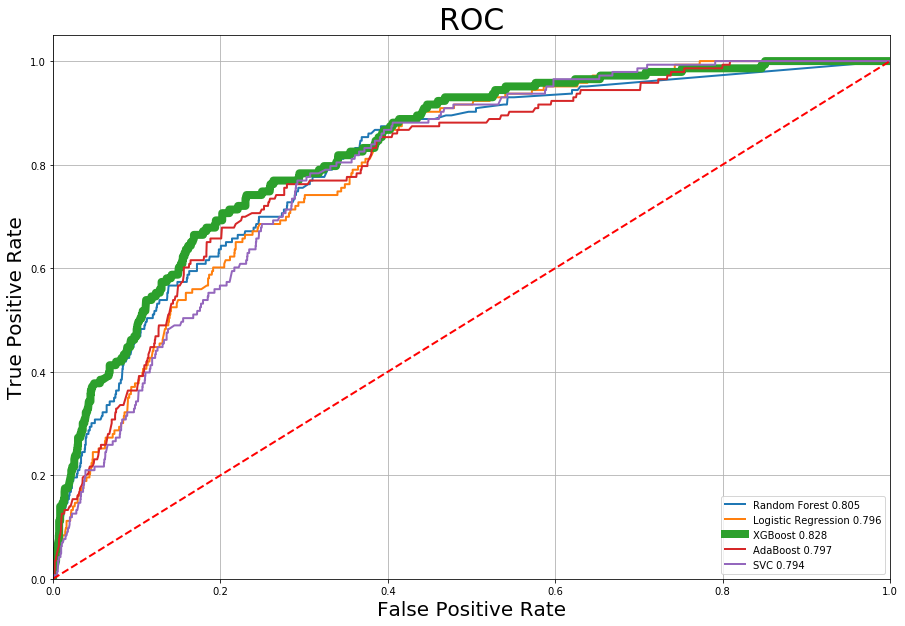

In [80]:
rf_fpr, rf_tpr, _ = roc_curve(rf_df['WnvPresent'], rf_df['predicted_proba'])
rf_roc_auc = auc(rf_fpr, rf_tpr)
logreg_fpr, logreg_tpr, _ = roc_curve(logreg_df['WnvPresent'], logreg_df['predicted_proba'])
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
xgm_fpr, xgm_tpr, _ = roc_curve(xgm_df['WnvPresent'], xgm_df['predicted_proba'])
xgm_roc_auc = auc(xgm_fpr, xgm_tpr)
ada_fpr, ada_tpr, _ = roc_curve(ada_df['WnvPresent'], ada_df['predicted_proba'])
ada_roc_auc = auc(ada_fpr, ada_tpr)
svc_fpr, svc_tpr, _ = roc_curve(svc_df['WnvPresent'], svc_df['predicted_proba'])
svc_roc_auc = auc(svc_fpr, svc_tpr)
# Plot
fig = plt.figure(figsize=(15,10))
line_width = 2

plt.plot(rf_fpr, rf_tpr, lw=line_width, label=f"Random Forest {round(rf_roc_auc, 3)}")
plt.plot(logreg_fpr, logreg_tpr, lw=line_width, label=f"Logistic Regression {round(logreg_roc_auc, 3)}")
plt.plot(xgm_fpr, xgm_tpr, lw=8, label=f"XGBoost {round(xgm_roc_auc, 3)}")
plt.plot(ada_fpr, ada_tpr, lw=line_width, label=f"AdaBoost {round(ada_roc_auc, 3)}")
plt.plot(svc_fpr, svc_tpr, lw=line_width, label=f"SVC {round(svc_roc_auc, 3)}")

plt.plot([0,1], [0,1], lw=line_width, linestyle='--', color='r')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC', fontsize=30)
plt.legend(loc="lower right")
plt.grid(True)

In [65]:
X_resample['Cool_s1'].describe()

count    14942.000000
mean         9.189239
std          5.182950
min          0.000000
25%          6.000000
50%         10.000000
75%         13.000000
max         19.000000
Name: Cool_s1, dtype: float64